## IMPORTS

In [ ]:
import pandas as pd
import community.community_louvain
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Model
from keras.layers import Input, Dense

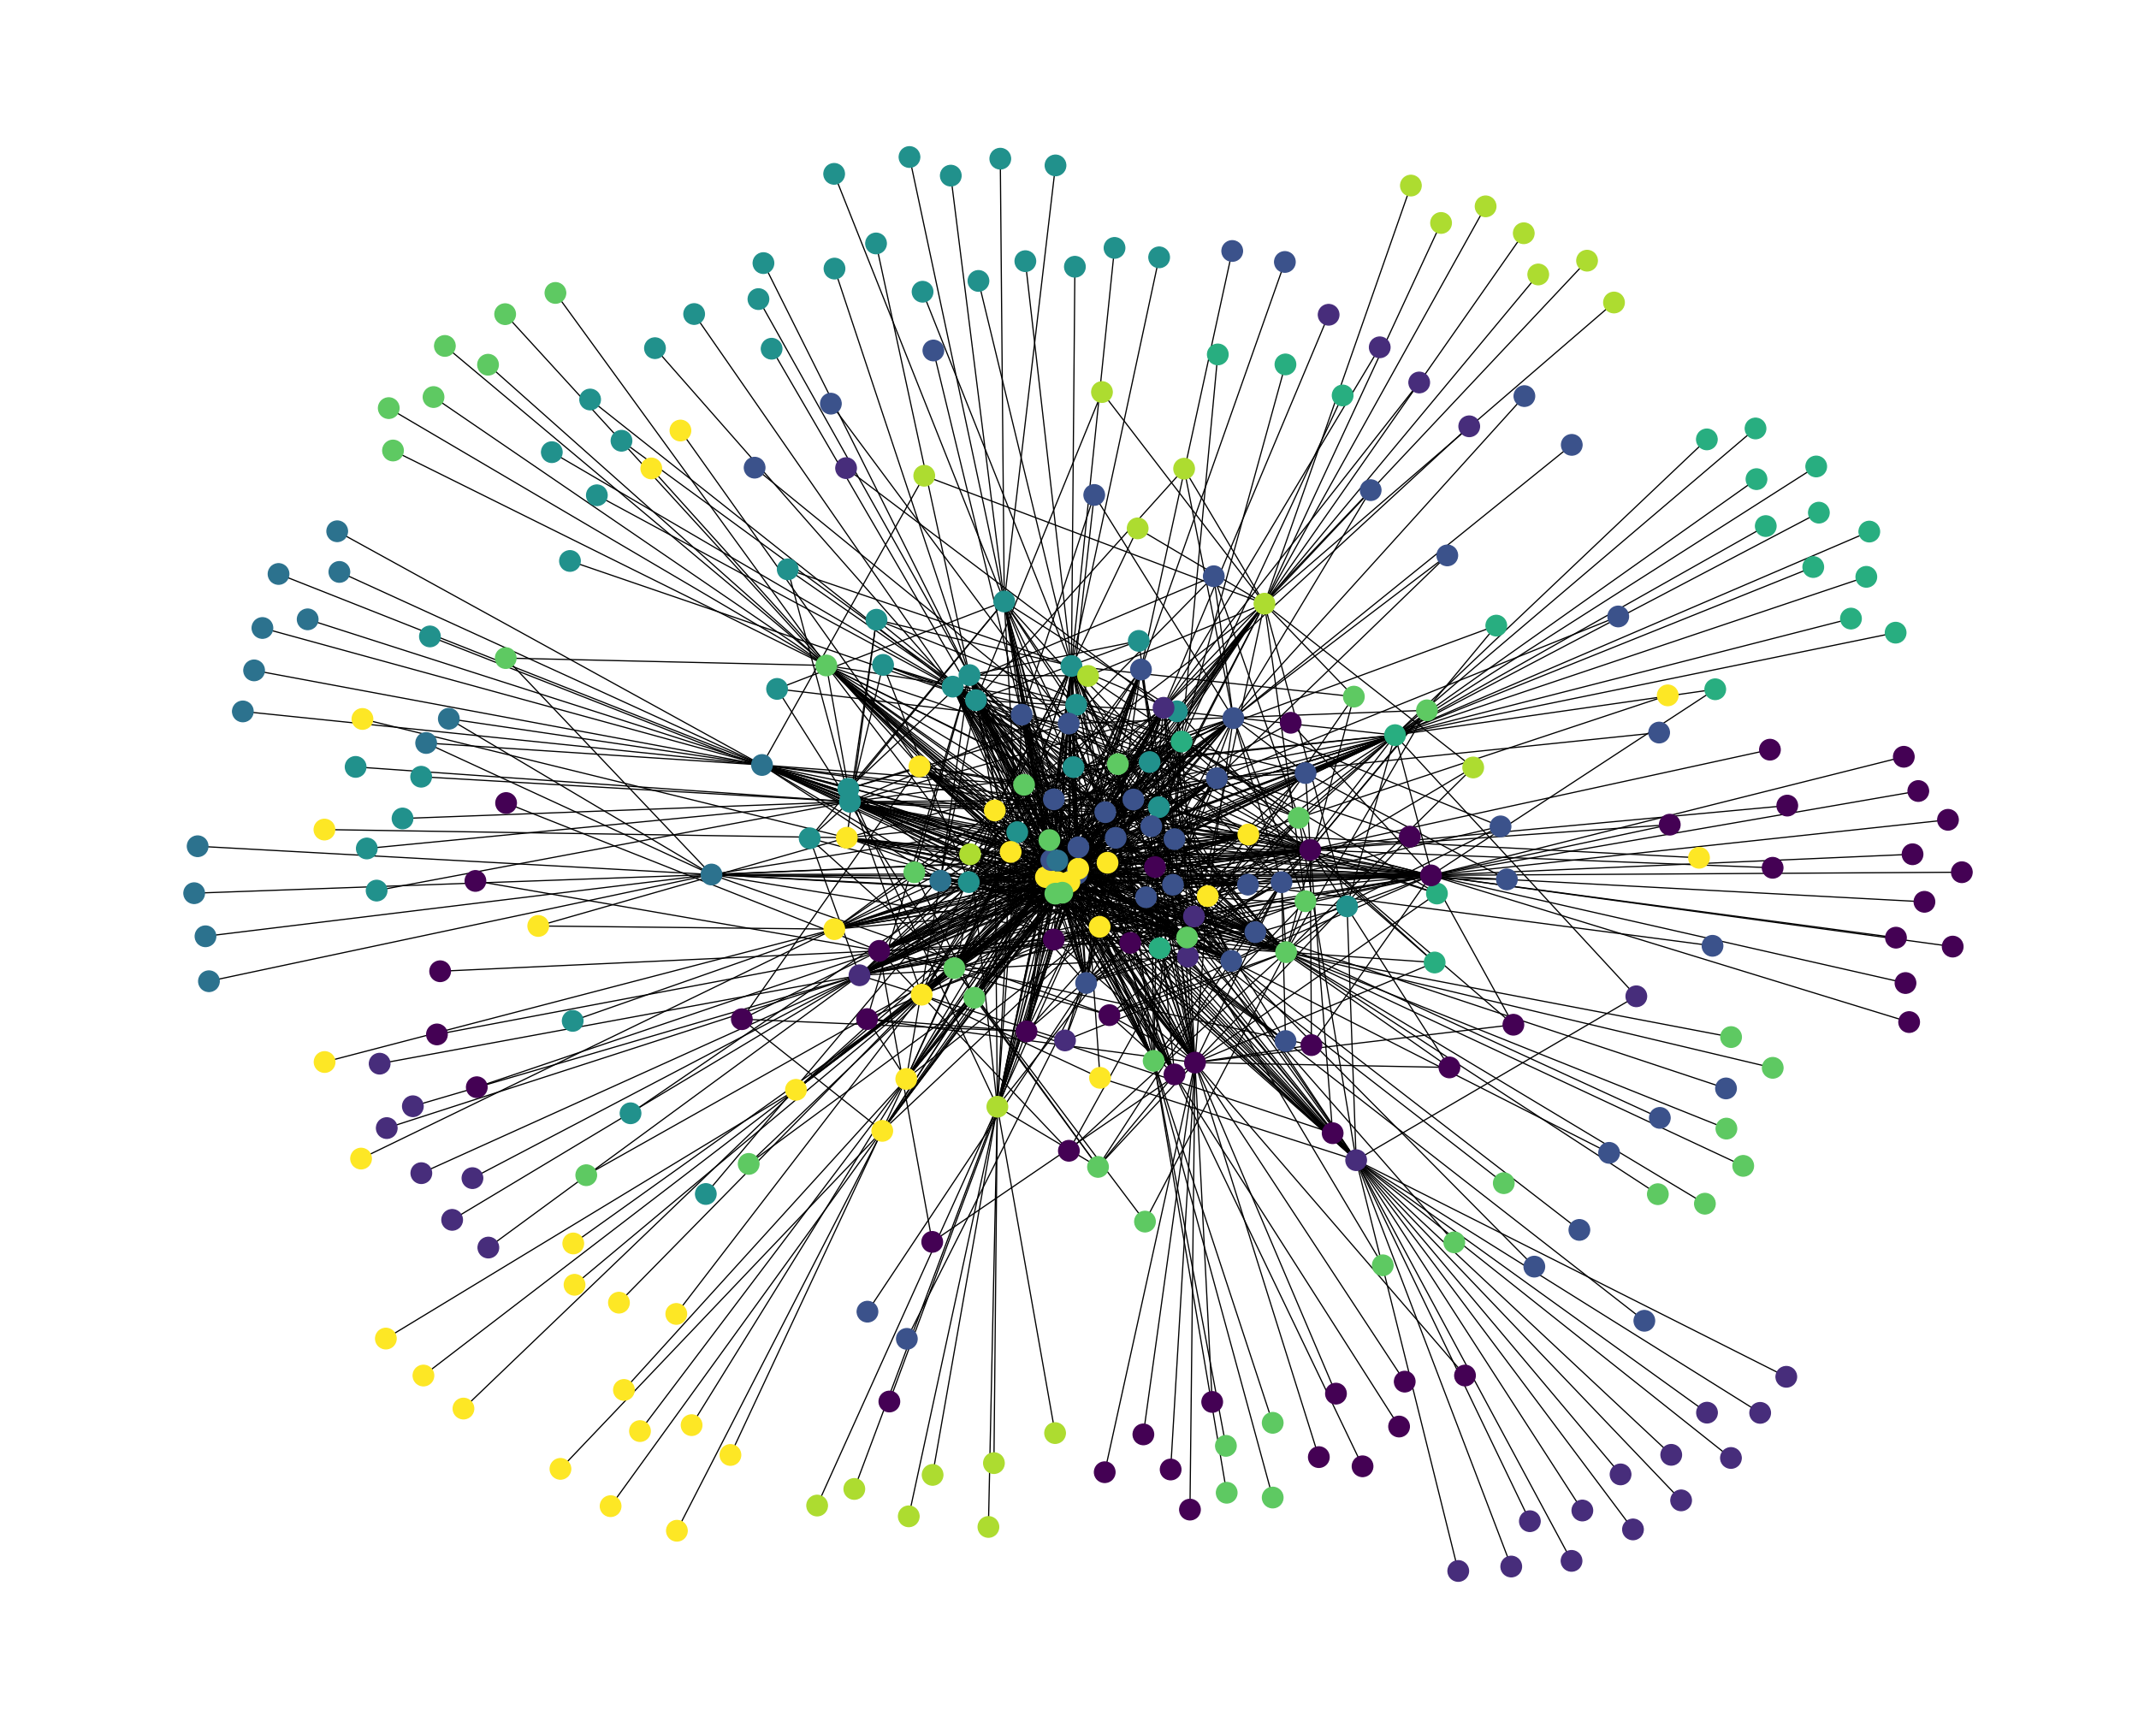

In [3]:
df = pd.read_csv('sysmonlogs.csv')
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'computer_name','Image')

part = community.community_louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

figure(figsize=(25, 20))
nx.draw_spring(G, node_color=values,with_labels=False)

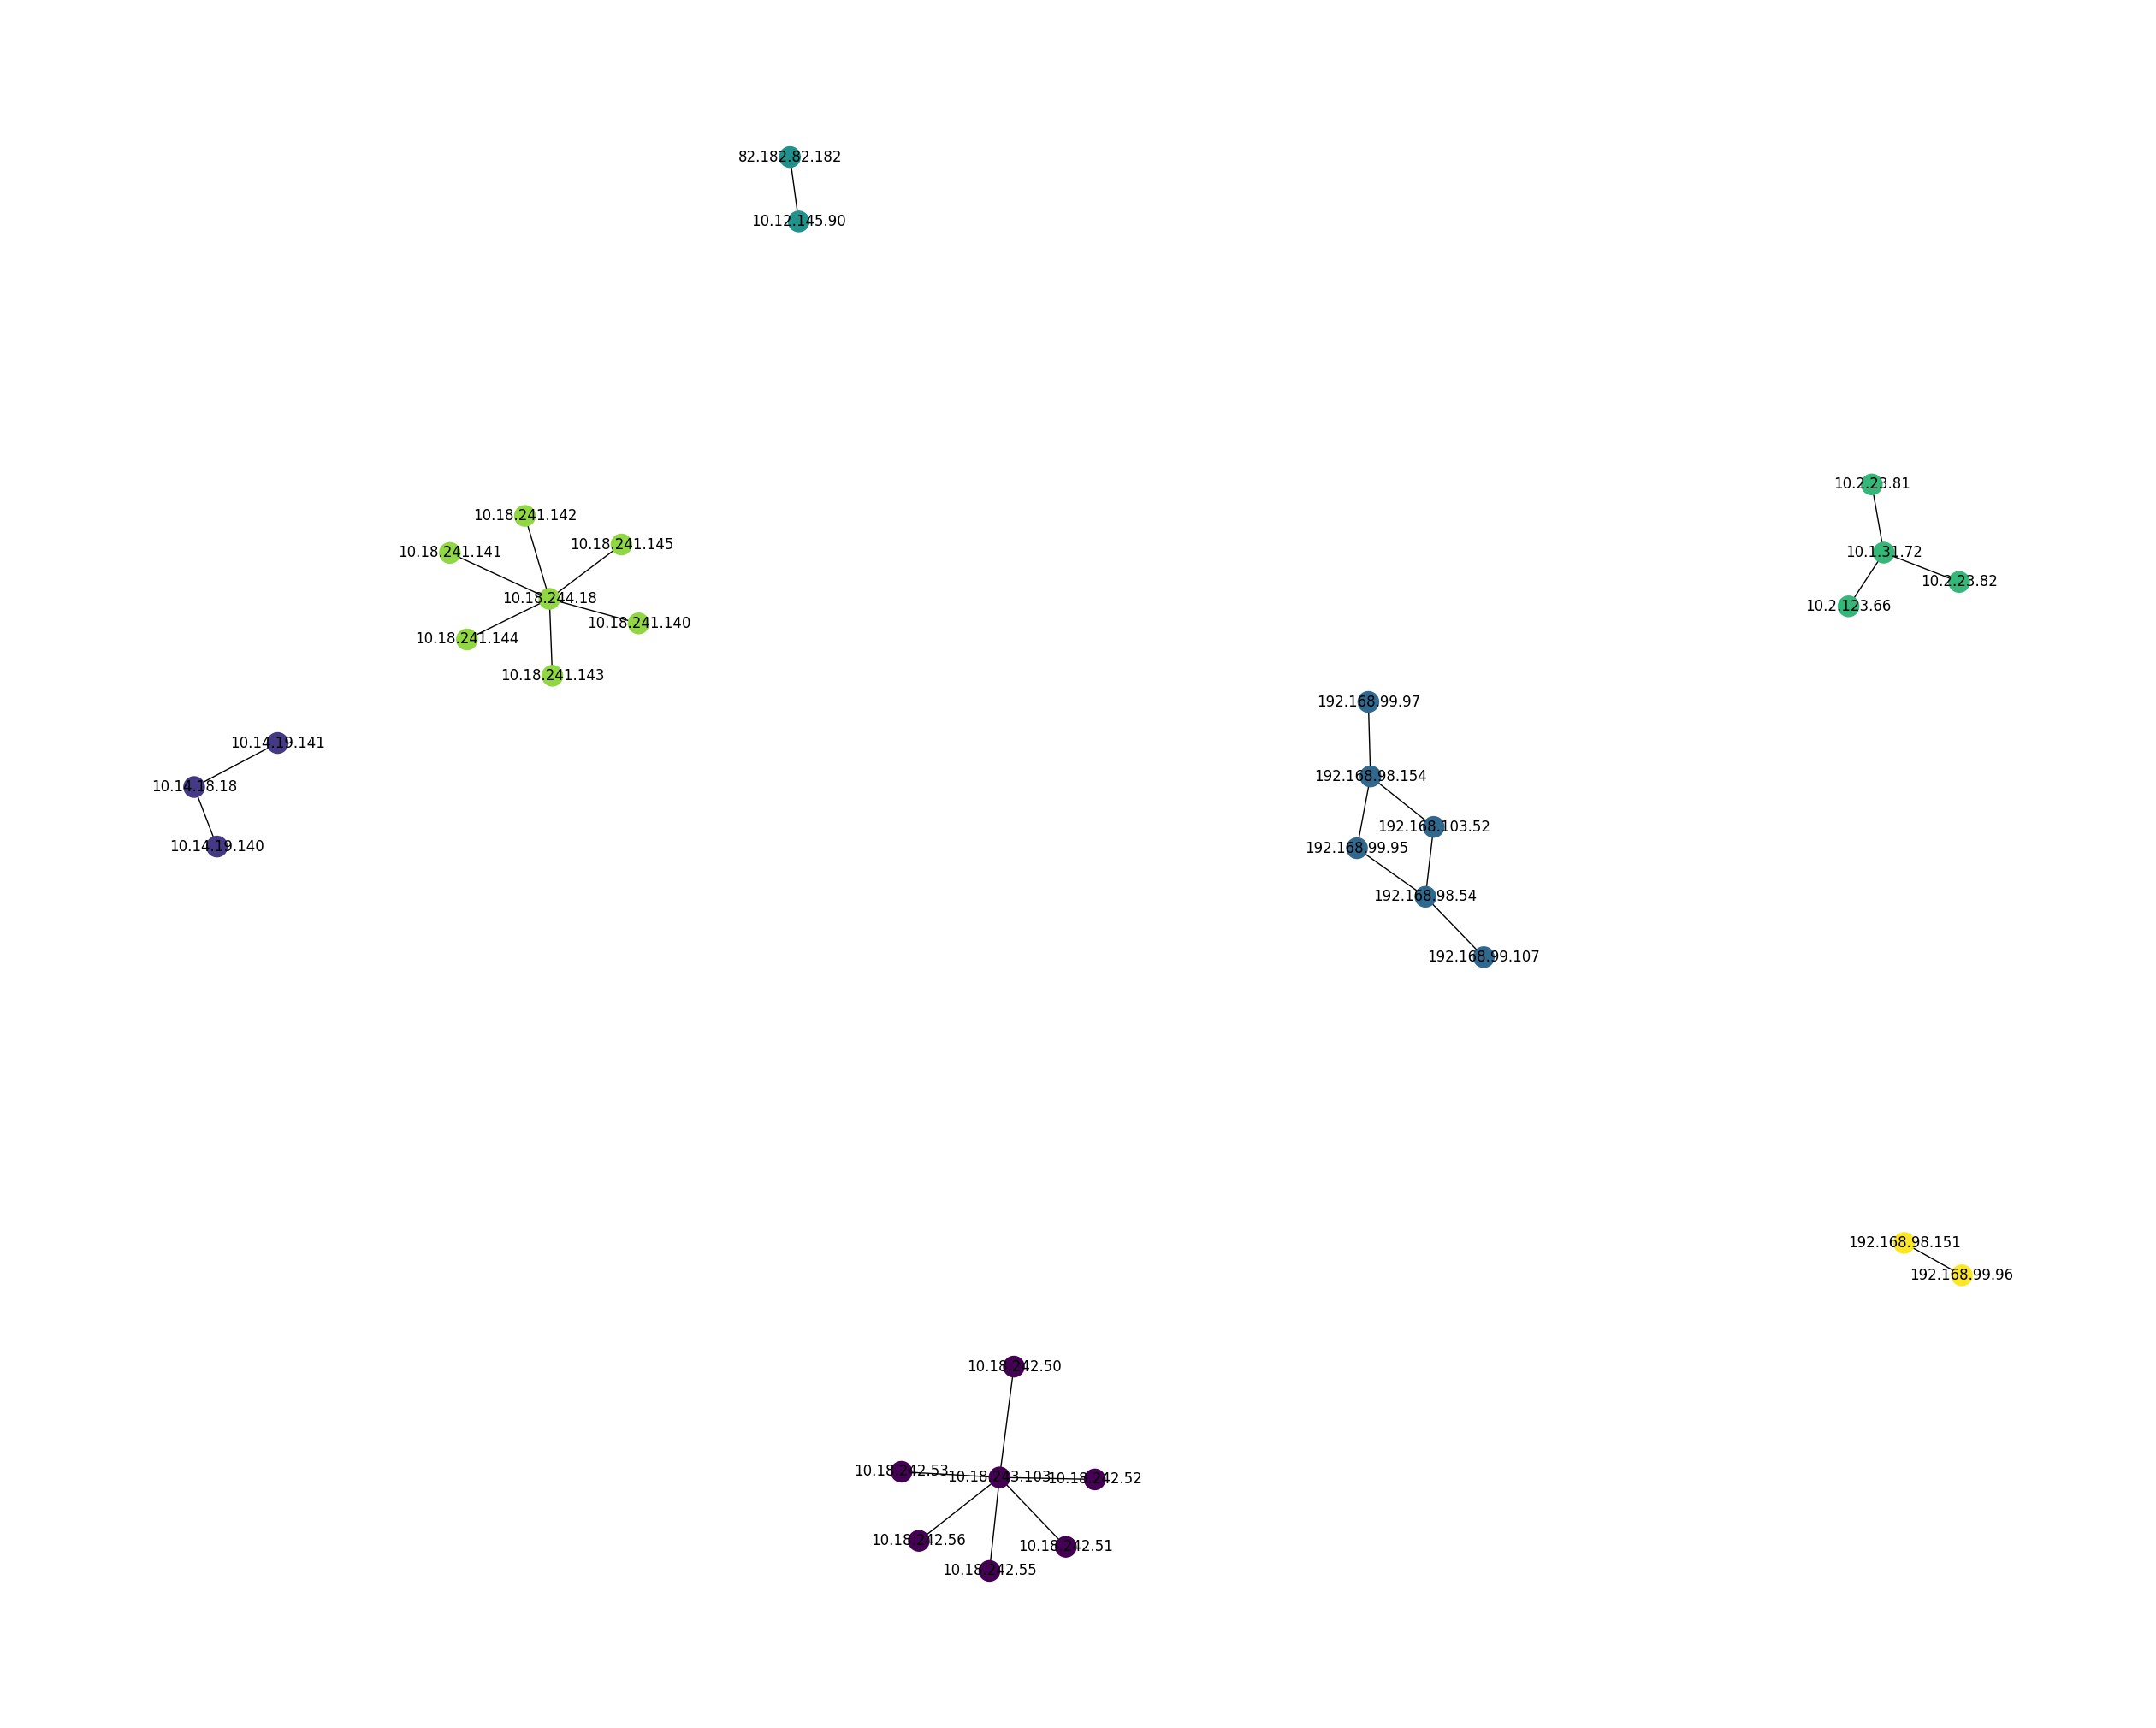

In [12]:
# Read Data
df_spark = spark.read.csv("MODBUS1.csv", header=True, inferSchema=True)

df_pandas = df_spark.select("src_ip", "dest_ip").dropna().toPandas()

# Create Graph
G = nx.from_pandas_edgelist(df_pandas, 'src_ip', 'dest_ip')

# Community Detection & Visualization
part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]

figure(figsize=(25, 20))
nx.draw_spring(G, node_color=values, with_labels=True)


## Let's get some ML in

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Start Spark session
spark = SparkSession.builder \
    .appName("MODBUS Autoencoder") \
    .getOrCreate()

# Load data
df = spark.read.csv("MODBUS1.csv", header=True, inferSchema=True)

# Pre-processing
df = df.fillna({"dest_port": 0, "func": "UNKNOWN"})
pandas_df = df.toPandas()
original_rows = pandas_df.copy()

# Select relevant features
feature_df = pandas_df[["dest_port", "func"]].copy()

# One-hot encode the 'func' column
encoder = OneHotEncoder(sparse=False)
func_encoded = encoder.fit_transform(feature_df[["func"]])
func_feature_names = encoder.get_feature_names_out(["func"])

# Create a DataFrame with encoded columns
func_df = pd.DataFrame(func_encoded, columns=func_feature_names)
combined_df = pd.concat([feature_df[["dest_port"]], func_df], axis=1)

# Normalize features
scaled_data = MinMaxScaler().fit_transform(combined_df)

# --- AUTOENCODER MODEL ---

input_dim = scaled_data.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(scaled_data, scaled_data, epochs=20, batch_size=16, shuffle=True, verbose=0)

reconstructions = autoencoder.predict(scaled_data)
mse = np.mean(np.power(scaled_data - reconstructions, 2), axis=1)

# Set threshold
threshold = np.percentile(mse, 95)
anomaly_indices = np.where(mse > threshold)[0]

# Show the anomalies
anomalies = original_rows.iloc[anomaly_indices]
anomalies


3/3 [==============================] - 0s 2ms/step


,Time,src_ip,dest_ip,dest_port,func
4,"April 7, 2025 @ 19:56:03.279",10.18.243.103,10.18.242.56,502,WRITE_MULTIPLE_REGISTERS
38,"April 7, 2025 @ 19:55:45.582",82.182.82.182,10.12.145.90,502,WRITE_SINGLE_REGISTER
51,"April 7, 2025 @ 19:55:40.961",192.168.98.151,192.168.99.96,502,WRITE_SINGLE_REGISTER
54,"April 7, 2025 @ 19:55:40.237",10.18.243.103,10.18.242.56,502,WRITE_MULTIPLE_REGISTERS


In [ ]:
import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder \
    .appName("MODBUS Autoencoder") \
    .getOrCreate()

# Load data
df = spark.read.csv("MODBUS.csv", header=True, inferSchema=True)

# Pre-processing
df = df.fillna({"quantity": 0, "dest_port": 0})
pandas_df = df.toPandas()
original_rows = pandas_df.copy()

# Select features
feature_columns = ["dest_port", "quantity"]
scaled_data = MinMaxScaler().fit_transform(pandas_df[feature_columns])

# Build and train autoencoder
input_dim = scaled_data.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(4, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(scaled_data, scaled_data, epochs=20, batch_size=16, shuffle=True, verbose=0)

# Predict and calculate reconstruction error
reconstructions = autoencoder.predict(scaled_data)
mse = np.mean(np.power(scaled_data - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
anomaly_indices = np.where(mse > threshold)[0]

# Print full anomalous rows
anomalies = original_rows.iloc[anomaly_indices]
anomalies


3/3 [==============================] - 0s 5ms/step


,Time,src_ip,dest_ip,dest_port,func,values,network_direction,quantity
1,None,None,None,0,None,None,None,0
45,"April 7, 2025 @ 19:56:27.307",192.168.98.150,192.168.99.177,502,READ_HOLDING_REGISTERS,"6154,5132,9483,8249,12593,21076,21815,8224,822...",response,85


## MODBUS Detections (Scanning & Disruption)

1. T0840: Maps all MODBUS registers to understand the network

2. T0859: New accounts using predefined account names for persistence

3. T0866: Uses regular polling intervals to mimic normal PLC communication

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("MODBUS_Detection").getOrCreate()

# Load MODBUS data
df = spark.read.csv("modbus_logs.csv", header=True, inferSchema=True)

# Preprocess
df = df.withColumn("timestamp", to_timestamp(col("Time"), "MMM dd, yyyy @ HH:mm:ss.SSS"))

# Detection 1: T1592 - Network Scanning (Register Mapping)
scan_detection = df.filter(
    (col("func") == "READ_HOLDING_REGISTERS") &
    (col("quantity") > 50) &
    (~col("src_ip").isin(whitelist)) \
    .join(
        df.groupBy("src_ip").agg(countDistinct("dest_ip").alias("unique_targets") \
          .filter(col("unique_targets") > 3),
        "src_ip"
    ).withColumn("ttp", lit("T0840: Network Scanning"))

# Detection 2: T0859 - Valid Accounts Abuse
valid_account_abuse = df.filter(
    # Default credentials
    ((col("username").isin(["admin", "guest", "operator"])) &
    (col("password").isin(["admin", "password", "1234"]))) |
    # Credential reuse patterns
    (col("src_ip") != lag("src_ip").over(Window.partitionBy("username").orderBy("timestamp")))
).withColumn("ttp", lit("T0859: Valid Accounts Abuse"))

# Detection 3: T0866 - Exploit Remote Services
exploit_detection = df.filter(
    (col("dest_port") == 502) &
    (
        # Malformed MODBUS ADU
        (length(col("payload")) < 6) |  # Min MODBUS TCP ADU size
        # Invalid function codes
        (col("func_code").isin(["0x00", "0x7F"])) |
        # Excessive registers (DoS)
        (col("quantity") > 125)
    )
).withColumn("ttp", lit("T0866: MODBUS Exploit"))

spark.stop()

## Ethernet/IP Detections (Program Upload & Parameter Hijacking)

1. T0845: Uploads malicious firmware from a PLC to gather information about an industrial process

2. T0831:  Changing control paths to set point values, tags, or other parameters

3. T0866: Sends malformed packets to enable remote service abuse

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("EthernetIP_Detection").getOrCreate()

df = spark.read.csv("ethernetip_logs.csv", header=True, inferSchema=True)

# Detection 1: T0845 - Program Upload
program_upload = df.filter(
    (col("enip_command").isin(["Upload", "ProgramTransfer"])) &
    (~col("src_ip").isin(authorized_programs)) # Unauthorized sources
).withColumn("ttp", lit("T0845: Program Upload"))

# Detection 2: T0831 - Manipulation of Control
control_manipulation = df.filter(
    (col("enip_command") == "Set_Attribute_Single") &
    (col("class") == "8") &  # IO Connection class
    (col("attribute") == "3")  # Connection Path
).withColumn("ttp", lit("T0831: Manipulation of Control"))

# Detection 3: T0866 - Exploit Remote Services
exploit_detection = df.filter(
    (col("length") < 24) |  # Malformed packet
    (col("service_code") == "0x00")  # Reserved/unused service codes
).withColumn("ttp", lit("T0866: Exploit Remote Services"))

# Combine and save results
program_upload.union(control_manipulation).union(exploit_detection) \
    .withColumn("critical", 
        when(col("dest_ip").isin(critical_assets), "HIGH")
        .otherwise("MEDIUM")) \
    .write.mode("overwrite").parquet("ethernetip_corrected_detections.parquet")

spark.stop()

## DNP3 Detections (Freeze Attacks & Alarm Suppression)

1. T0861: Bulk reads of analog inputs/output

2. T0801: Monitoring breaker status before triggering attacks

3. T0831: Manipulate control systems devices to communicate and command physical control processes

In [ ]:
spark = SparkSession.builder.appName("DNP3_Discovery_Detection").getOrCreate()

# Load and validate DNP3 data
df = spark.read.csv("dnp3_logs.csv", header=True, inferSchema=True) \
    .filter(col("protocol") == "DNP3") \
    .withColumn("timestamp", to_timestamp(col("Time")))

# Whitelist known engineering stations
authorized_clients = ["10.0.100.5", "192.168.1.20"]

# Detection 1: T0861 - Point & Tag Identification
tag_identification = df.filter(
    (col("function_code") == "READ") &
    (col("object_header").isin(["20", "21", "30"])) &  # Analog Input/Output, Counter
    (col("quantity") > 50) &  # Bulk reads
    (~col("src_ip").isin(authorized_clients))
).withColumn("ttp", lit("T0861: Point/Tag Identification"))

# Detection 2: T0801 - Process State Monitoring
process_monitoring = df.filter(
    (col("function_code") == "READ") &
    (col("object_header").isin(["40", "41"])) &  # Analog Output Status, Binary Output Status
    (col("interval").between(1000, 5000)) &  # 1-5 second polling
    (count("*").over(Window.partitionBy("src_ip", "object_prefix").rowsBetween(-10, 0)) > 8)
).withColumn("ttp", lit("T0801: Process State Monitoring"))

# Detection 3: T0831 - Manipulation of Control
control_manipulation = df.filter(
    col("function_code").isin(["DIRECT_OPERATE", "SELECT_AND_OPERATE"]) &
    (col("qualifier_code") == "0x28")  # No range, single object
).withColumn("ttp", lit("T0831: Manipulation of Control"))

# Combine and save results
tag_identification.union(process_monitoring).union(control_manipulation) \
    .withColumn("severity", 
        when(col("ttp").contains("Manipulation"), "CRITICAL")
        .otherwise("HIGH")) \
    .write.mode("overwrite").parquet("dnp3_discovery_detections.parquet")

spark.stop()

## BACnet Detections (HVAC Compromise)

1. T0861: Collects point and tag values to understand process environment

2. T0801: Gathers information about physical process state

3. T0846: Discovers remote systems by scanning network

In [ ]:
spark = SparkSession.builder.appName("BACnet_Detection").getOrCreate()

df = spark.read.csv("bacnet_logs.csv", header=True, inferSchema=True)

# Detection 1: T0861 - Point & Tag Identification
point_collection = df.filter(
    (col("object_type").isin(["AnalogValue", "BinaryValue", "MultiStateValue"])) &
    (col("service").isin(["ReadProperty", "ReadPropertyMultiple"])) &
    (col("property").isin(["presentValue", "description", "objectName"]))
).withColumn("ttp", lit("T0861: Point & Tag Identification"))

# Detection 2: T0801 - Monitor Process State
process_monitoring = df.filter(
    (col("service") == "ReadProperty") &
    (col("object_type").isin(["AnalogInput", "BinaryInput", "MultiStateInput"])) &
    (col("property") == "presentValue") &
    (col("count").cast("integer") > 100)  # High frequency polling
).withColumn("ttp", lit("T0801: Process State Monitoring"))

# Detection 3: T0846 - Remote System Discovery
network_scanning = df.filter(
    (col("service").isin(["Who-Is", "I-Am"])) &
    (size(col("device_instances")) > 50)  # Large number of devices discovered
).withColumn("ttp", lit("T0846: Remote System Discovery"))

point_collection.union(process_monitoring).union(network_scanning) \
    .write.mode("overwrite").parquet("bacnet_volt_typhoon_detections.parquet")

spark.stop()